# Thesis random sweeps - 3Try - Receptive Field width effect

3/3

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

In [11]:
with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_fisher2016_random_large_3try_010916.py

In [12]:
dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', 
                label='thesis_' + dataset_infos['save_output_filename'])
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fisherinfo_new_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_large_3try_repetitions3_010916/outputs/thesis_rcwidtheffect_rnd-<module>-2219a14b-7016-4ad5-ad16-2198add21855 ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_large_3try_repetitions3_010916/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fisherinfo_new_2016/fisher2016_random_large_3try_repetitions3_010916_outputs
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_large_3try_repetitions3_010916/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fisherinfo_new_2016/fisher2016_random_large_3try_repetitions3_010916_outputs


In [13]:
def avg_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(array, axis=-1))]
def avg_twice_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(utils.nanmean(array, axis=-1), axis=-1))]


def process_precision(array_name, array):
    outputs = avg_lastaxis(array_name, array)
    outputs.extend(avg_lastaxis(array_name + "_stddev", (2./array)**0.5))
    return outputs
    
def process_fi(array_name, array):
    outputs = avg_twice_lastaxis(array_name, array)
    outputs.extend(avg_twice_lastaxis(array_name + "_stddev", (2./array)**0.5))
    return outputs

def process_marginal_fi(array_name, array):
    # Marginal FI/Inv FI have (mean, std), just keep mean
    outputs_all = avg_lastaxis(array_name, array)
    
    if array_name.find('inv') > -1:
        outputs_all.extend(avg_lastaxis(array_name + "_stddev", (2.*array)**0.5))
    else:
        outputs_all.extend(avg_lastaxis(array_name + "_stddev", (2./array)**0.5))
    
    outputs = [(o[0], o[1][:, 0]) for o in outputs_all]
    return outputs

def process_em_fits(array_name, array):
    emfits_all = utils.nanmean(array, axis=-1)
    outputs = [(array_name + "_" + colname, emfits_all[:, col_i])
            for col_i, colname in enumerate(['kappa',
                                             'target',
                                             'nontargets',
                                             'random',
                                             'LL',
                                             'bic'])
              ]
    outputs.append((array_name + '_fidelity', 1./utils.kappa_to_stddev(emfits_all[:, 0])**2.))
    outputs.append((array_name + '_stddev', utils.kappa_to_stddev(emfits_all[:, 0])))
    
    return outputs

    
def construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions):
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    filter_data = None
    result_parameters_flat = None

    pandas_column_data = []

    for result_array_name, result_processing in pandas_columns_with_processing:
        # Extract data
        res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'])

        # Filter completed only
        if filter_data is None:
            repeats_completed = data_pbs.dict_arrays[result_array_name]['repeats_completed']
            filter_data = repeats_completed == (num_repetitions - 1)
        res_array = res_array[filter_data]

        # Keep parameters
        if result_parameters_flat is None:
            result_parameters_flat = np.array(data_pbs.dict_arrays[result_array_name]['parameters_flat'])
            result_parameters_flat = result_parameters_flat[filter_data]

        # Transform into list of columns for Pandas
        pandas_column_data.extend(result_processing['process'](result_processing['name'], res_array))

    # Add all parameters to Pandas columns
    for param_i, param_name in enumerate(parameter_names_sorted):
        pandas_column_data.append((param_name, result_parameters_flat[:, param_i]))
    
    df_out = pd.DataFrame.from_items(pandas_column_data)
    
    # Remove NaN
    df_out = df_out.dropna()
    
    return df_out

In [14]:
def remove_outliers(df, n_stddev=5):
    outliers = np.sum(np.abs(spst.zscore(df)) < n_stddev, axis=-1)
    return df[outliers >= outliers.max()]

In [15]:
def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.qcut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, (param_name + "_qi")] = param_factored
    
    return df, param_qbins, param_qbins_middle

In [16]:
def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    if filter_mask is None:
        return df
    else:
        return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi

    return filter_dataframe(df, quantized_parameters_targets)

In [17]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

In [19]:
parameter_names_sorted = ['rc_scale']

In [20]:
T_space = data_pbs.loaded_data['parameters_uniques']['T']
rc_scale_space = data_pbs.loaded_data['parameters_uniques']['rc_scale']

pandas_columns_with_processing = [
    ('result_all_precisions', dict(name='precision', process=process_precision)),
    ('result_FI_rc_curv', dict(name='fi_curv', process=process_fi)),
    ('result_FI_rc_theo', dict(name='fi_theo', process=process_fi)),
    ('result_FI_rc_theocov', dict(name='fi_theo_cov', process=process_fi)),
    ('result_marginal_FI', dict(name='fi_marginal', process=process_marginal_fi)),
    ('result_marginal_inv_FI', dict(name='inv_fi_marginal', process=process_marginal_fi)),
    ('result_em_fits', dict(name='emfit', process=process_em_fits)),
]

df_all_fits = construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)
df_all_fits.loc[:, ('T')] = df_all_fits.loc[:, ('T')].astype(int)
df_all_fits.loc[:, ('fi_fidelity_ratio')] = df_all_fits['fi_theo']/(2*df_all_fits['emfit_fidelity'])
df_all_fits.loc[:, ('fi_stddev_ratio')] = df_all_fits['fi_theo_stddev']/(df_all_fits['emfit_stddev'])
df_all_fits.loc[:, ('margfi_stddev_ratio')] = df_all_fits['inv_fi_marginal_stddev']/(df_all_fits['emfit_stddev'])

df_all_fits = df_all_fits[df_all_fits['inv_fi_marginal_stddev'] < 1.5*np.pi]

In [21]:
df_all_fits.describe()

,precision,precision_stddev,fi_curv,fi_curv_stddev,fi_theo,fi_theo_stddev,fi_theo_cov,fi_theo_cov_stddev,fi_marginal,fi_marginal_stddev,...,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,T,rc_scale,fi_fidelity_ratio,fi_stddev_ratio,margfi_stddev_ratio
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000
mean,13.150865,1.032543,139.956168,0.139651,125.072624,0.188791,125.072624,0.188791,113.038953,0.147551,...,2.647375e-01,-88.064497,192.023945,46.766788,0.149306,1.0,29.854992,1.385125,1.275352,1.003509
std,20.293423,0.618150,15.142929,0.047022,9.813225,0.077488,9.813225,0.077488,45.927296,0.070267,...,2.196343e-01,146.089358,292.178717,12.918423,0.032013,0.0,17.235313,0.274623,0.961730,0.939959
min,0.200678,0.167166,0.572517,0.117311,0.189866,0.126108,0.189866,0.126108,0.189866,0.105583,...,9.795527e-10,-366.114557,-269.326753,0.527188,0.031929,1.0,0.011253,0.000130,0.835340,0.630465
25%,0.788025,0.376969,132.559758,0.125705,123.075301,0.133384,123.075301,0.133384,72.180570,0.113751,...,2.897140e-02,-228.471700,-126.367168,39.978141,0.137079,1.0,14.905248,1.156971,0.970825,0.765475
50%,1.753387,1.076016,140.082577,0.130570,125.458636,0.174426,125.458636,0.174426,122.105048,0.127982,...,2.471573e-01,-113.270515,242.435982,45.693624,0.147935,1.0,29.426029,1.375938,1.091490,0.898534
75%,15.133831,1.600534,150.762761,0.151344,128.649336,0.231216,128.649336,0.231216,154.578527,0.166489,...,4.747036e-01,71.131060,472.838353,53.218213,0.158157,1.0,44.535945,1.581687,1.488814,1.063755
max,71.642055,3.174398,167.286756,2.168814,154.028788,3.245575,154.028788,3.245575,179.414160,3.245575,...,8.326958e-01,142.610853,748.124065,980.929545,1.377264,1.0,59.993929,2.767352,87.736088,87.736088


In [13]:
# Remove outliers
df_fits_filtered = remove_outliers(df_all_fits, 10)

In [14]:
df_fits_filtered.describe()

,precision,precision_stddev,fi_curv,fi_curv_stddev,fi_theo,fi_theo_stddev,fi_theo_cov,fi_theo_cov_stddev,fi_marginal,fi_marginal_stddev,...,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,T,rc_scale,fi_fidelity_ratio,fi_stddev_ratio,margfi_stddev_ratio
count,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,...,9.969000e+03,9969.000000,9969.000000,9969.000000,9969.000000,9969.0,9969.000000,9969.000000,9969.000000,9969.000000
mean,13.177281,1.032306,140.359125,0.137800,125.430857,0.186810,125.430857,0.186810,113.359766,0.145442,...,2.652198e-01,-87.776749,191.448449,46.794135,0.148068,1.0,29.947556,1.386596,1.264970,0.992281
std,20.318269,0.617410,13.320791,0.015270,7.416468,0.054583,7.416468,0.054583,45.634188,0.041711,...,2.194777e-01,146.086120,292.172241,8.653239,0.013834,0.0,17.181840,0.273123,0.382135,0.314013
min,0.409930,0.167166,28.101740,0.117311,27.622120,0.126108,27.622120,0.126108,27.622120,0.105583,...,9.795527e-10,-307.991531,-269.326753,12.896144,0.094852,1.0,0.188383,0.544584,0.835340,0.630465
25%,0.787990,0.374665,132.622784,0.125681,123.096012,0.133335,123.096012,0.133335,72.845543,0.113688,...,2.953172e-02,-228.287317,-127.154496,40.028374,0.137058,1.0,15.075952,1.158462,0.971075,0.765232
50%,1.749181,1.078201,140.161120,0.130548,125.477512,0.174112,125.477512,0.174112,122.205792,0.127938,...,2.482962e-01,-112.962340,241.819633,45.748321,0.147847,1.0,29.580113,1.377850,1.092115,0.897632
75%,15.289915,1.600611,150.816220,0.151163,128.664655,0.230811,128.664655,0.230811,154.745572,0.165700,...,4.753318e-01,71.524724,472.469585,53.234538,0.158058,1.0,44.564276,1.582953,1.489327,1.064631
max,71.642055,2.223398,167.286756,0.270353,154.028788,0.364008,154.028788,0.364008,179.414160,0.269083,...,6.880517e-01,142.610853,631.878015,111.149217,0.278465,1.0,59.993929,2.767352,3.143231,2.554241


## Metrics

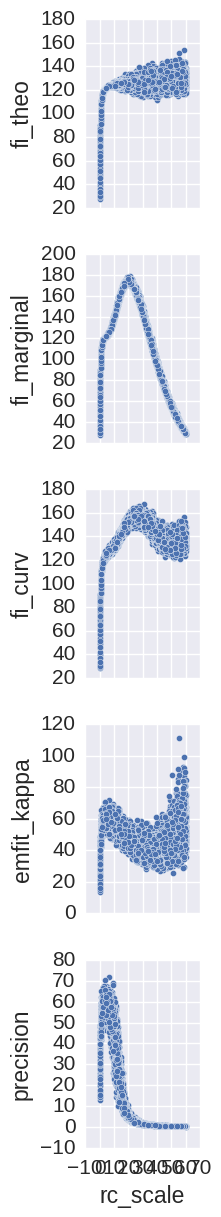

In [15]:
# Check parameters effects
sns.pairplot(df_fits_filtered,
             x_vars=parameter_names_sorted,
             y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa', 'precision']
            )



## Quantize parameters

In [16]:
nQuantiles = 100
parameters = ['rc_scale']
df_fits_filtered_q = df_fits_filtered[df_fits_filtered.rc_scale < 30]

df_singleitem = filter_dataframe(df_fits_filtered_q, dict(T=1))
df_quantized, param_qbins, param_qbins_middle = df_add_quantize_parameters(df_singleitem, parameters, nQuantiles)

In [17]:
def plot_mean_std_df(df, x_col, y_col, param_qbins_middle, xlabel=None, ylabel=None, ax=None):
    df_mean = df.groupby(x_col + "_qi").mean()
    df_std = df.groupby(x_col + "_qi").std()
    return utils.plot_mean_std_area(param_qbins_middle[x_col], 
                                    df_mean[y_col],
                                    df_std[y_col],
                                    xlabel=xlabel,
                                    ylabel=ylabel,
                                    ax_handle=ax,
                                    label=y_col
                                   )

## Plotting metrics vs rc_scale

In [18]:
df_quantized['fi_marginal_half'] = df_quantized['fi_marginal']/2
df_quantized['fi_theo_half'] = df_quantized['fi_theo']/2

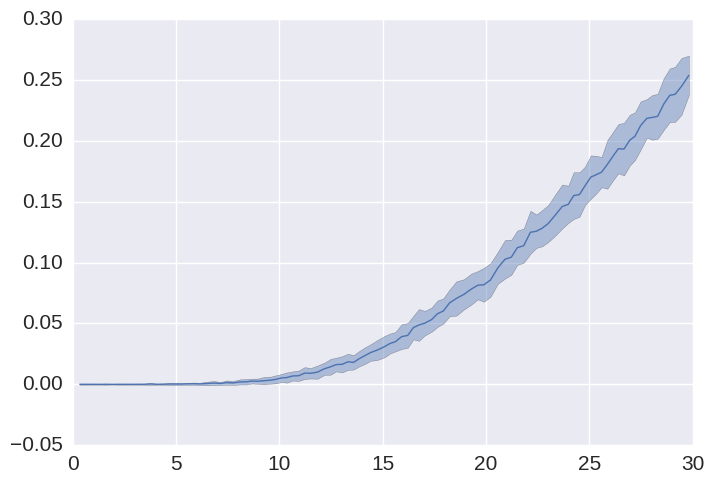

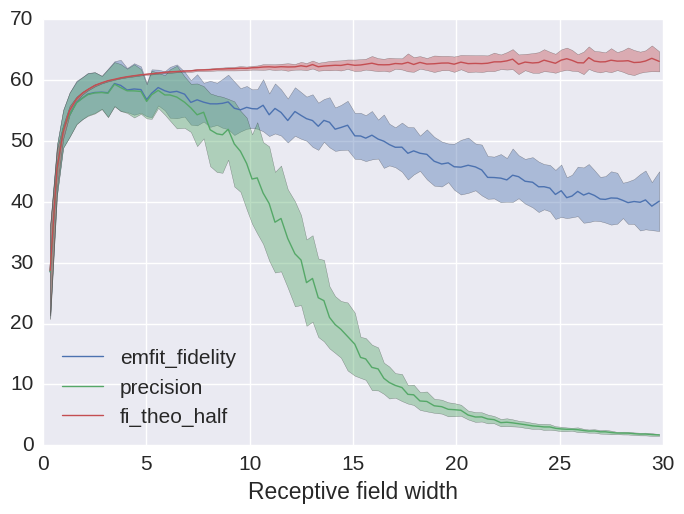

In [34]:
ax = plot_mean_std_df(df_quantized, 'rc_scale', 'emfit_random', param_qbins_middle)
ax = plot_mean_std_df(df_quantized, 'rc_scale', 'emfit_fidelity', param_qbins_middle)
ax = plot_mean_std_df(df_quantized, 'rc_scale', 'precision', param_qbins_middle, ax=ax)
ax = plot_mean_std_df(df_quantized, 'rc_scale', 'fi_theo_half', param_qbins_middle, ax=ax)
ax.set_xlabel("Receptive field width")
plt.legend(loc='best')

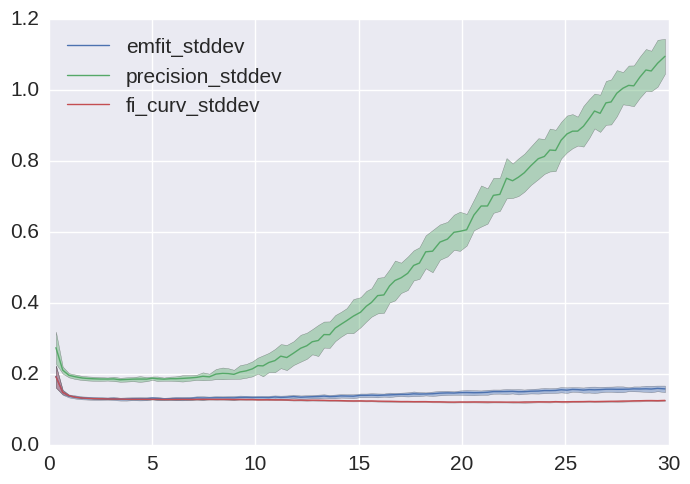

In [20]:
ax = plot_mean_std_df(df_quantized, 'rc_scale', 'emfit_stddev', param_qbins_middle)
ax = plot_mean_std_df(df_quantized, 'rc_scale', 'precision_stddev', param_qbins_middle, ax=ax)
ax = plot_mean_std_df(df_quantized, 'rc_scale', 'fi_curv_stddev', param_qbins_middle, ax=ax)
plt.legend(loc='best')